# Welcome to homework 3 by WIlly G
Let's do some imports.

In [5]:
%matplotlib inline

import scipy.io
from sklearn import svm
from sklearn.preprocessing import normalize
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt
from scipy.stats import multivariate_normal


from skimage.feature import hog
from skimage import data, color, exposure

Time to get some awesome data for MNIST and do some dundiddly preprocessing.

Starting!
Data loaded!
Featurization progress: 1
Featurization progress: 10001
Featurization progress: 20001
Featurization progress: 30001
Featurization progress: 40001
Featurization progress: 50001
Featurization progress: 1
6


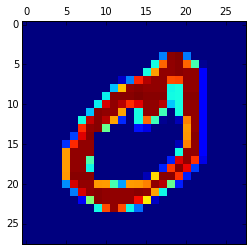

In [12]:
def featurize(image, i ):
    lol = image.reshape(28,28)
    extra1 = hog(lol, orientations=8, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualise=True)
    extra2 = hog(lol, orientations=8, pixels_per_cell=(7, 7), cells_per_block=(1, 1), visualise=True)
    pixelvector = list(image* 1/255.0*2 - 1)
    if (i-1) % 10000 == 0:
        print("Featurization progress: %s" % i)
    pixelvector.extend(list(extra1[1].flatten()*1/255.0*4))
    pixelvector.extend(list(extra2[1].flatten()*1/255.0*4))
    return np.array(pixelvector)

print("Starting!")

image_train = scipy.io.loadmat("../data/digit_dataset/train.mat")
image_test = scipy.io.loadmat("../data/digit_dataset/test.mat")['test_images']

image_train_data_raw =  image_train['train_images']
image_train_label_raw =  image_train['train_labels']

print("Data loaded!")
image_tdata = np.array([featurize(image_train_data_raw[:,:,i].flatten(), i) for i in range(len(image_train_data_raw[0,0]))])
image_tlabel = image_train_label_raw.ravel()

image_test_data = np.array([featurize(test.reshape(28,28).T.flatten(), i) for i, test in enumerate(image_test)])

#Shuffle that image data good.
shuffle = np.random.permutation(np.arange(image_tdata.shape[0]))
image_tdata, image_tlabel = image_tdata[shuffle], image_tlabel[shuffle]

#VALIDATION
image_valid_data  =  image_tdata[0:10000]
image_valid_label = image_tlabel[0:10000]

#TRAINING
image_train_data  =image_tdata[10000:]
image_train_label =image_tlabel[10000:]

plt.matshow(image_train_data_raw[:,:,1])
print(image_train_label[0]) #unrelated to the plot!

Did you like that. I did. Okay so, let's make a class which model data classes!

In [13]:
def perturb_eig(mat, alpha):
    return mat + alpha*np.eye(mat.shape[0])



class dataclass:
    def __init__(self, datum, labels, class_label, alpha):
        # Find all of the datapoints in datum with the labels class_lab.
        # add them to this dataclass
        ids_classc = [idx for idx,label in enumerate(labels) if label == class_label ]
        self.data = datum[ids_classc]
        
        #calculate some things!
        singcov = np.cov(self.data.T)
        self.mean = np.mean(self.data, axis = 0)
        self.prior = len(ids_classc)/len(labels)
        
        #Let's make sure we can invert the covariance matrix using a bincary searach.
        self.cov = singcov
        
        self.gaussian = multivariate_normal(self.mean, self.cov, True)
        self.covall = None
        
    def lda(self, covall, x):
        if self.covall is covall:
            return self.ldagaussian.logpdf(x) + self.prior
        else:
            self.covall =covall
            self.ldagaussian = multivariate_normal(self.mean, covall, True)
            return self.ldagaussian.logpdf(x) + self.prior
    
    def qda(self, x):
        return self.gaussian.pdf(x)*self.prior

We gotta make sure this class makes sense

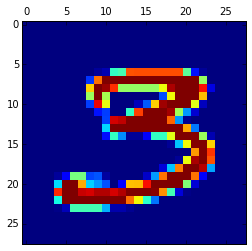

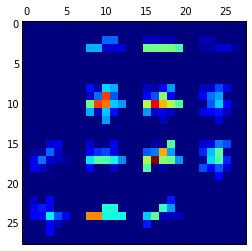

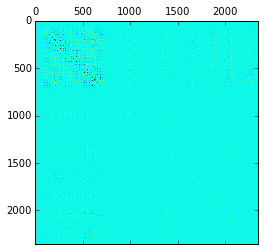

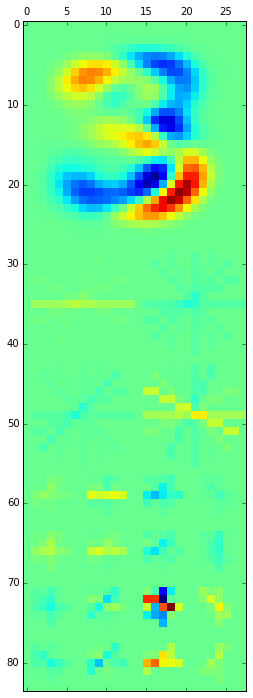

In [17]:
a = dataclass(image_train_data, image_train_label, 3.0, 0.1)

plt.matshow(a.data[0][0:28*28].reshape(28,28))
plt.matshow(a.data[0][28*28*2:].reshape(28,28))
plt.matshow(a.cov)

plt.matshow(a.cov[1333,:].reshape(56+28,28))

Let's actually make all of the image classes!

In [18]:
image_train_class = [dataclass(image_train_data, image_train_label, float(x), 0.1) for x in range(10)]

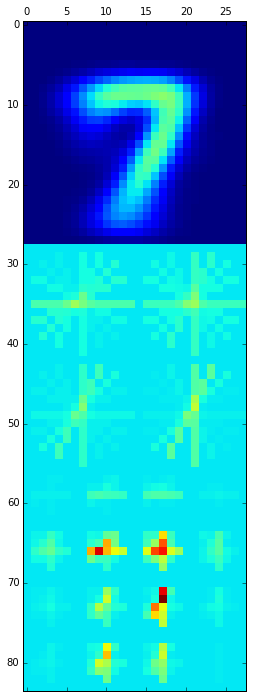

In [19]:
plt.matshow(image_train_class[7].mean.reshape((56+28,28)))

Well that worked thank god!
Now we need to add all of those peski general properties

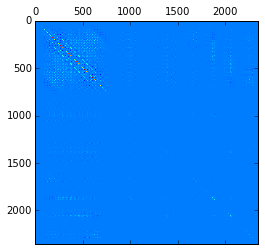

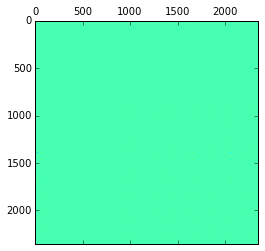

In [20]:
covall = 0.1*np.sum([image_train_class[i].cov for i in range(len(image_train_class))], axis=0)
precall = np.linalg.pinv(covall)
plt.matshow(covall)
plt.matshow(precall)

# Question 5 part(d)

Now we make some helper methods.

In [21]:
def best_prediction(classes,method,  x):
    return np.argmax(list(map(lambda cls: method(cls, x), classes)))

def validate(classes, method,  x, y):
    if int(best_prediction(classes, method, x)) == int(y):
        return 1.0
    else:
        return 0

def lda(cls, x):
    return cls.lda(covall, x)

def qda(cls, x):
    return cls.qda(x)
    
def experiment(method, num_class, train_data, train_labels, validation, labels, samples=1000000000):
    classes = [dataclass(train_data[0:samples], train_labels[0:samples], float(x), 0.1) for x in range(num_class)]
    print("classes created for experiment!")
    net = 0
    for idx, sample in enumerate(validation):
        score = validate(classes, method, sample, labels[idx])
        net += score
        
    return 1.0 - net/len(validation)

def do_test(method, num_class, train_data, train_labels, test_data):
    classes = [dataclass(train_data, train_labels, float(x), 0.1) for x in range(num_class)]
    print("classes classes created for test!")
    pred = [int(best_prediction(classes, method, test)) for test in test_data]
    pairs = list(enumerate(pred))
    for idx, pair in enumerate(pairs):
        pairs[idx] =(pair[0]+1, pair[1])
    return pairs

experiment_count = [100,200, 500, 1000, 2000, 5000, 10000, 30000, 50000]

Now we can actually run some experiments

LDA
Running at 100,
classes created for experiment!
	Error: 0.6674
Running at 200,
classes created for experiment!
	Error: 0.36329999999999996
Running at 500,
classes created for experiment!
	Error: 0.13729999999999998
Running at 1000,
classes created for experiment!
	Error: 0.08689999999999998
Running at 2000,
classes created for experiment!
	Error: 0.06969999999999998
Running at 5000,
classes created for experiment!
	Error: 0.061000000000000054
Running at 10000,
classes created for experiment!
	Error: 0.05740000000000001
Running at 30000,
classes created for experiment!
	Error: 0.054200000000000026
Running at 50000,
classes created for experiment!
	Error: 0.05410000000000004


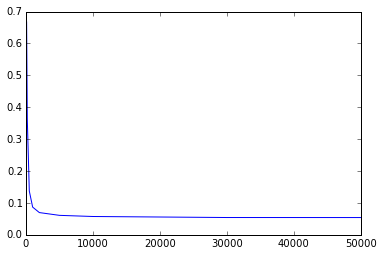

In [22]:
#LDA
print("LDA")
errors = []
for count in experiment_count:
    print("Running at %s," %  count)
    error = experiment(lda, 10, image_train_data,image_train_label , image_valid_data, image_valid_label, count)
    print("\tError: %s" % error)
    errors.append(error)
    
plt.plot(experiment_count, errors)
plt.show()

QDA
Running at 100,
classes created for experiment!
	Error: 0.9071
Running at 200,
classes created for experiment!
	Error: 0.8905
Running at 500,
classes created for experiment!
	Error: 0.7746
Running at 1000,
classes created for experiment!
	Error: 0.2619
Running at 2000,
classes created for experiment!
	Error: 0.17300000000000004
Running at 5000,
classes created for experiment!
	Error: 0.7823
Running at 10000,
classes created for experiment!
	Error: 0.2914
Running at 30000,
classes created for experiment!
	Error: 0.14239999999999997
Running at 50000,
classes created for experiment!
	Error: 0.13470000000000004


/home/william/anaconda3/lib/python3.4/site-packages/scipy/stats/_multivariate.py:603: RuntimeWarning: overflow encountered in exp
  return np.exp(self.logpdf(x))


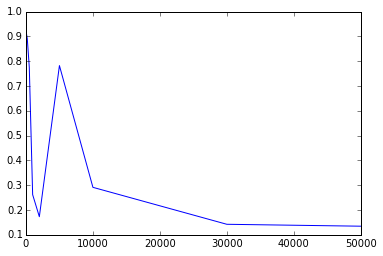

In [23]:
#QDA
print("QDA")
errors = []
for count in experiment_count:
    print("Running at %s," %  count)
    error = experiment(qda, 10, image_train_data, image_train_label, image_valid_data, image_valid_label, count)
    print("\tError: %s" % error)
    errors.append(error)
    
plt.plot(experiment_count, errors)
plt.show()

In [27]:
thedata = list(do_test(lda, 10, image_tdata, image_tlabel, image_test_data))
np.savetxt(
    'kaggleimage.csv',           # file name
    thedata,                # array to save
    fmt='%i',             # formatting, 2 digits in this case
    delimiter=',',          # column delimiter
    newline='\n')

classes classes created for test!


Now let's do the spam thing and work it all out!

In [25]:
spam_data = scipy.io.loadmat("../data/spam_dataset/spam_data.mat")
spam_train = spam_data['training_data']
spam_test = spam_data['test_data']

spam_train_data_raw =  spam_train
spam_train_label_raw =  spam_data['training_labels']

spam_tlabel = spam_train_label_raw.ravel()
div_train = [1.0/max(arr) for arr in spam_train_data_raw.T]
spam_tdata = np.array([np.multiply(dp, div_train) for dp in spam_train_data_raw ])
spam_test_data = np.array([np.multiply(dp, div_train) for dp in spam_test ])

#Shuffle that spam data good.
shuffle = np.random.permutation(np.arange(spam_tdata.shape[0]))
spam_tdata, spam_tlabel = spam_tdata[shuffle], spam_tlabel[shuffle]

#VALIDATION
spam_valid_data  =  spam_tdata[0:750]
spam_valid_label = spam_tlabel[0:750]

#TRAINING
spam_train_data  =spam_tdata[750:]
spam_train_label =spam_tlabel[750:]


Looks good! Let's train on everything and build a Kaggle.

In [26]:
thedata = list(do_test(qda, 2, spam_tdata, spam_tlabel, spam_test_data))
np.savetxt(
    'kagglespam.csv',           # file name
    thedata,                # array to save
    fmt='%i',             # formatting, 2 digits in this case
    delimiter=',',          # column delimiter
    newline='\n')

classes classes created for test!


# Linear Regressive
Let's do it! We know that $\langle w, x\rangle = \hat y$. Therefore, we can consider the following line
of reasoning.

Let $X$ be the design matrix containing all of the data points. Since for each data point there is weight whose dot product yeilds an entry of the final output $y$, we let $w$ be some weight vector, along which we will multiply each data point. This gives
$$Xw = y.$$

Performing a pseudo inverse will give us the least squares solution $w = (X^TX)^{-1}X^Ty$.

In [142]:
def linreg(data, y, alpha=0):
    #Add one to all the data points.
    extended = np.array([np.append(sample, [1]) for sample in data])
    print(extended)
    w = np.dot(np.dot(np.linalg.inv(np.dot(extended.T, extended)), extended.T), y)
    return w

def linrss(data, y, w):
    extended = np.array([np.append(sample, [1]) for sample in data])
    return np.linalg.norm(np.dot(extended,w) - y,2)**2

def plot_weights(w):
    plt.bar(range(len(w)-1),w[:-1])

[[ 0.   1. ]
 [ 1.   1. ]
 [ 1.2  1. ]
 [ 1.5  1. ]
 [ 2.   1. ]]
0.0133120437956


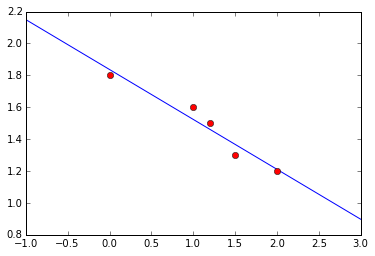

In [143]:
test = np.array([[0],[1],[1.2],[1.5],[2]])
test_y = np.array([1.8,1.6,1.5,1.3,1.2])

w = linreg(test,test_y, 0)
#plot_weights(w)

X = np.array([[-1,1],
            [-0.5,1],
            [0,1],
            [0.5,1],
            [1,1],
             [1.5,1],
             [2,1],
             [2.5,1],
             [3,1]])
x = np.array([-1,-0.5,0,0.5,1,1.5,2,2.5,3])

plt.plot(x, np.dot(X,w))
plt.plot(test, test_y, 'ro')

print(linrss(test, test_y, w))

In [149]:
real_data =  scipy.io.loadmat("../data/housing_dataset/housing_data.mat")
real_Xtrain = (real_data['Xtrain'])/ np.linalg.norm((real_data['Xtrain']),2)
real_Ytrain = real_data['Ytrain'].ravel()/np.linalg.norm(real_data['Ytrain'].ravel(),2)
real_Xvalidate = real_data['Xvalidate'] /np.linalg.norm(((real_data['Xvalidate'])),2)
real_Yvalidate = real_data['Yvalidate'].ravel()/np.linalg.norm(real_data['Yvalidate'].ravel(),2)

[[  5.32672469e-06   5.82932150e-05   1.97286100e-03 ...,   6.92960594e-05
   -2.20621602e-04   1.00000000e+00]
 [  8.92487339e-06   6.19365410e-05   6.02241778e-03 ...,   6.92049762e-05
   -2.23244797e-04   1.00000000e+00]
 [  9.20449865e-06   4.73632372e-05   4.10967166e-03 ...,   6.94600090e-05
   -2.20967718e-04   1.00000000e+00]
 ..., 
 [  2.73249445e-06   7.10448558e-05   1.84898791e-03 ...,   6.79480288e-05
   -2.19473955e-04   1.00000000e+00]
 [  1.69068540e-05   5.64715521e-05   4.94945829e-03 ...,   6.80573285e-05
   -2.22388615e-04   1.00000000e+00]
 [  5.94208244e-06   9.47264744e-05   6.59077662e-03 ...,   6.89499434e-05
   -2.22716515e-04   1.00000000e+00]]
613157.990429


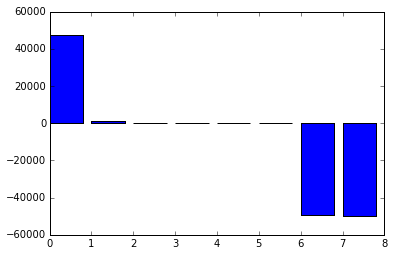

In [151]:
w = linreg(real_Xtrain, real_Ytrain)

plot_weights(w)
print(linrss(real_Xvalidate, real_Yvalidate, w))

(array([   4.,   21.,  102.,  423.,  553.,   81.,    6.,    4.,    5.,    1.]),
 array([ 20.43552208,  20.97386487,  21.51220766,  22.05055045,
         22.58889324,  23.12723604,  23.66557883,  24.20392162,
         24.74226441,  25.28060721,  25.81895   ]),
 <a list of 10 Patch objects>)

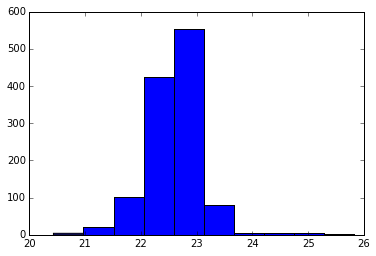

In [154]:
extended = np.array([np.append(sample, [1]) for sample in real_Xvalidate])
plt.hist(np.dot(extended, w) - real_Yvalidate)